[Qibo 0.2.21|INFO|2025-10-11 16:05:56]: Using qibojit (numba) backend on /CPU:0


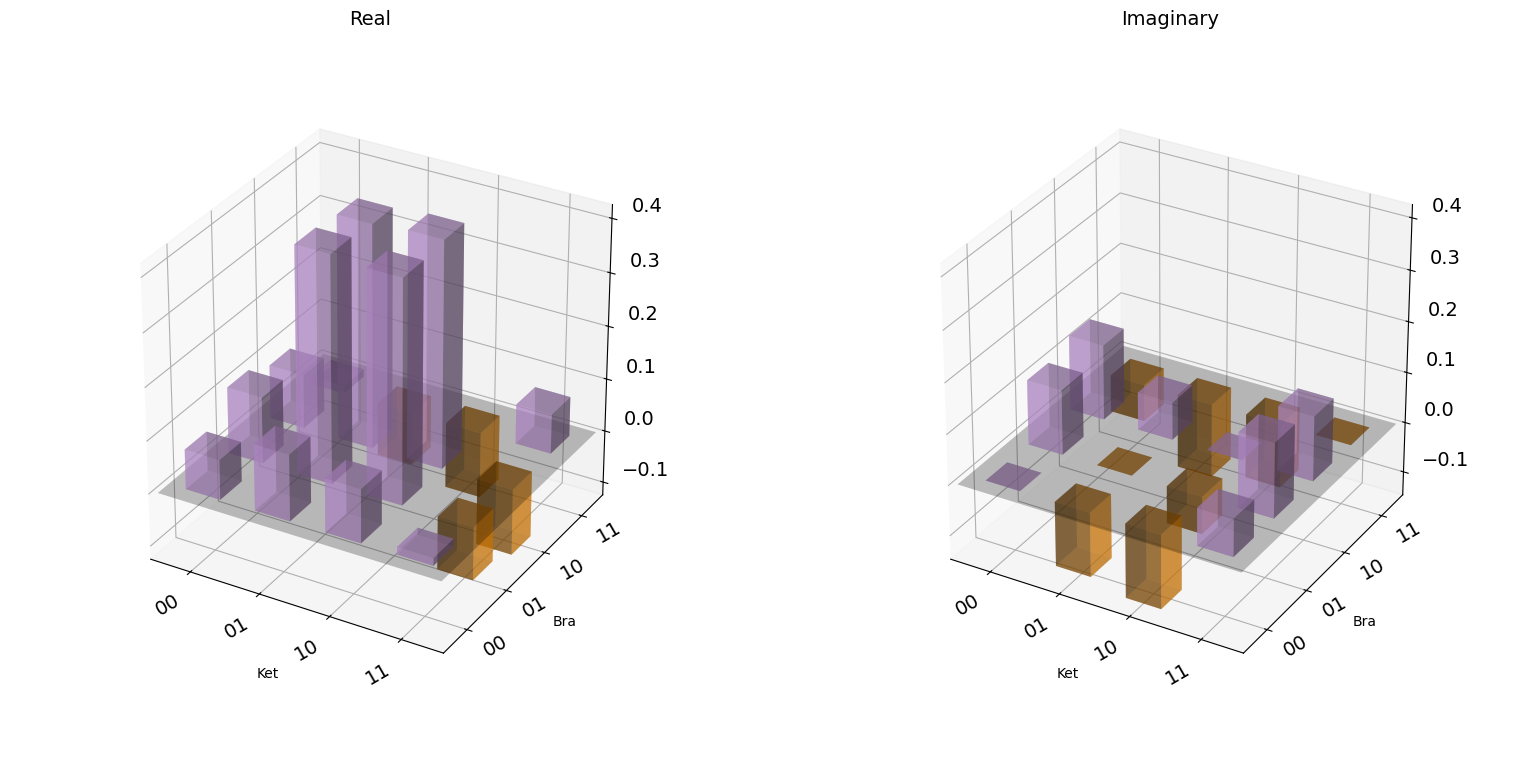

In [ ]:
import numpy as np  # 导入NumPy库，用于数学计算
from qibo import Circuit, gates  # 从qibo库导入Circuit类和gates模块，用于构建量子电路
from qibo.ui import plot_density_hist  # 从qibo.ui导入plot_density_hist函数，用于绘制密度矩阵的直方图

# 创建一个包含2个量子比特的量子电路
circuit = Circuit(2)
# 在第一个量子比特上添加Hadamard门
circuit.add(gates.H(0))
# 在第二个量子比特上添加Hadamard门
circuit.add(gates.H(1))
# 添加一个控制Z门，作用于第一个和第二个量子比特
circuit.add(gates.CZ(0, 1))
# 在第一个量子比特上添加一个旋转Y门，旋转角度为π/3
circuit.add(gates.RY(0, theta=np.pi/3))
# 在第二个量子比特上添加一个旋转X门，旋转角度为π/5
circuit.add(gates.RX(1, theta=np.pi/5))

# 绘制电路的密度矩阵作为城市景观图（实部和虚部）
plot_density_hist(circuit);

# 如何为电路执行选择经典硬件设备？
Qibo 支持在不同的经典硬件配置上执行，包括具有多线程的 CPU、单个 GPU 和多个 GPU。在这里，我们提供一些有用的信息，说明如何控制 Qibo 用于电路执行的设备，以便在可用的经典硬件配置下最大限度地提高性能。

# 在 CPU 和 GPU 之间切换
如果系统中有支持 CUDA 的 GPU，并且安装了 tensorflow 或 qibojit（cupy），那么电路将自动在 GPU 上执行，除非用户另有指定。可以使用 qibo.set_device 更改默认的模拟设备：

In [2]:
import qibo
qibo.set_device("/CPU:0")
final_state = circuit() # circuit will now be executed on CPU

[Qibo 0.2.21|INFO|2025-10-11 16:12:47]: Using qibojit (numba) backend on /CPU:0


In [4]:
print(final_state)

(0.17406-0.21106j)|00> + (0.64958-0.05655j)|01> + (0.64958+0.05655j)|10> + (-0.17406-0.21106j)|11>


设备名称的语法遵循“/{设备类型}:{设备编号}”的模式，其中设备类型可以是CPU或GPU，设备编号是一个整数，用于区分同一类型的多个设备，从0开始。更多详情请参考TensorFlow关于手动设备放置的教程。此外，在终端中运行命令CUDA_VISIBLE_DEVICES=""会在此终端会话中隐藏CUDA GPU。

# 设置CPU线程数量
Qibo默认使用基于自定义算子的qibojit后端。该后端使用OpenMP指令进行并行处理。在大多数情况下，利用所有可用的CPU线程能提供更好的性能。不过，对于小型电路，并行化的开销可能会降低性能，此时单线程执行更为可取。

你可以通过在启动Qibo之前，设置OMP_NUM_THREADS环境变量并指定所需的线程数量来限制线程数，或者在运行时通过编程方式进行设置，具体如下：

In [5]:
import qibo
# set the number of threads to 1
qibo.set_threads(1)
# retrieve the current number of threads
current_threads = qibo.get_threads()

In [6]:
current_threads

1

# 多GPU使用

In [ ]:
from qibo import Circuit, gates

# 定义GPU配置
accelerators = {"/GPU:0": 3, "/GPU:1": 1}
# 这将使用第一个GPU三次和第二个GPU一次
# 导致总共四个逻辑设备
# 构建32个量子比特的分布式电路
circuit = Circuit(32, accelerators)

然后可以使用circuit.add正常添加门，并且可以使用circuit()执行电路。请注意，在分布式电路中会传入一个memory_device（如果不传入，默认会使用CPU）。该设备不执行任何门计算，仅用于存储完整状态。因此，分布式模拟受到CPU内存量的限制。

另外，需要注意的是，可以多次重用单个GPU，以增加分布式计算中的“逻辑”设备数量。这使得用户能够通过多次重用，使用accelerators = {"/GPU:0": ndevices}在单个GPU上执行超过30个量子比特的电路。此类模拟将仅受CPU内存的限制。

对于没有GPU的系统，分布式实现可以用于任何类型的设备。例如，如果有多个CPU，用户可以在加速器字典中传入这些CPU。

由于通信瓶颈，分布式电路通常比使用单个GPU要慢。然而，对于超过30个量子比特（单个GPU无法容纳）以及特定应用（如量子傅里叶变换），多GPU方案可能比仅使用CPU更快。

请注意，使用多个GPU模拟电路时，会将状态分割成多个部分，并分发到不同的设备上。将完整状态创建为单个张量需要合并这些部分，并且会使用两倍的内存。默认情况下这是禁用的，但用户可以按如下方式创建完整状态：